## Faster Projection-free Online Learning

#### Initialisation

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression

mnist_train = pd.read_csv("mnist_train.csv", header=None)
mnist_test = pd.read_csv("mnist_test.csv", header = None)


y_train = mnist_train.iloc[:,0]
X_train = mnist_train.iloc[:,1:]
X_train /= 255
X_train = np.array(X_train)
n,d = X_train.shape


y_test = mnist_test.iloc[:,0]
X_test = mnist_test.iloc[:,1:]
X_test /= 255
X_test = np.array(X_test)
ntest, dtest = X_test.shape



y_train = 2*np.array(y_train == 0)-1 # binary classification 
y_test = 2*np.array(y_test == 0)-1 

In [14]:
def hinge_reg_sgd(x, a, b, lamb):
    threshold = b*np.dot(a,x)[0]
    cost = np.maximum(1 - threshold,0)
    return cost + lamb*np.dot(x.T,x)/2

In [15]:
def grad_reg_sgd(x, a, b, lamb, d):
    threshold = b*np.dot(a,x)[0]

    if (threshold >= 1):
        grad = np.zeros(d)
    else:
        grad = -b*a

    return grad.reshape(d,) + lamb*x

In [16]:
def hingereg(x, a, b, lamb):
    threshold = np.multiply(np.dot(a,x), b) 
    cost = np.maximum(1 - threshold,0)
    return cost.mean() + lamb*np.dot(x.T,x)/2

In [17]:
def gradreg(x, a, b, lamb):
    n,d = a.shape
    threshold = np.multiply(np.dot(a,x) , b)
    grad = -np.multiply(a, b.reshape(b.shape[0],1))
    idx_zeros = (threshold >= 1)
    grad[idx_zeros,:] = np.zeros(d)
    return grad.sum(axis=0)/n + lamb*x

In [18]:
# Sample vector of dimension dim on the unit ball
def sample_ball(dim):
    u = np.random.normal(0,1,dim)
    norm=np.sum(u**2) **(0.5)
    r = np.random.rand()**(1.0/dim)
    x = r*u/norm
    return x

In [19]:
# Projection on the L2 ball
def proj_l2(x, z=1):
    norm = np.sqrt(np.sum(x**2))
    if (norm > z):
        x /= (norm/z)
    return x

In [20]:
# Simplex/ L1 ball projections

def proj_simplex(x, z=1):

    d = x.shape[0]
    x_sorted = -np.sort(-x) 
    x_cumsum = np.cumsum(x_sorted)
    find = x_sorted - (1/np.arange(1,d+1,1))*(x_cumsum - z)
    d0 = np.argmax(find <= 0) 
    theta_star = (1/d0)*(x_cumsum[d0-1] - z)

    return np.maximum(x-theta_star,0)


def proj_l1(x, z=1):
    x_abs = np.absolute(x)
    if (np.sum(x_abs) > z):
        p_simplex = proj_simplex(x_abs, z)
        sgn = 2*(x>0)-1
        x = np.multiply(sgn, p_simplex)    
    return x

In [21]:
def oracle_l1(x,z=10):
    idx = np.argmax(np.abs(x))
    sign = np.sign(x[idx])
    res = np.zeros(d) 
    res[idx] = z*sign
    return res

#### Algorithms

In [22]:
def OSPF(a, b, init, iters, cost,  grad, oracle, X_test = None, y_test = None, z=0.75, k=5, delta=1, lamb = (1/3)):

    start_time = time.time()
    n,d = a.shape
    
    indices = np.random.randint(0,n,iters)
    test_scores = []
    grad_sum = np.zeros(d)
    x_mean = init
    x_t = init

    
    for i in range(1,iters+1):
        delta = np.sqrt(1/i)

        
        if (i % k != 0):
            x_i = a[indices[i-1],:].reshape(1,d)
            y_i = b[indices[i-1]]
            grad_t = grad(x_t, x_i, y_i, lamb, d)
            grad_sum += grad_t
            
            x_mean += x_t
            test_score = (np.multiply(np.matmul(X_test,x_mean/i), y_test) > 0).mean() 
            test_scores.append(test_score)
            
            
        else:
            to_proj = [(1/delta)*sample_ball(d) -grad_sum for _ in range(k)]
            xj = np.array([oracle(x, z) for x in to_proj])
            x_t = np.mean(xj, axis=0)
            
            x_mean += x_t
            test_score = (np.multiply(np.matmul(X_test,x_mean/i), y_test) > 0).mean() 
            test_scores.append(test_score)
            
            
            x_i = a[indices[i-1],:].reshape(1,d)
            y_i = b[indices[i-1]]
            grad_t = grad(x_t, x_i, y_i, lamb, d)
            grad_sum += grad_t
        
        
    
    end_time = time.time()
    print("Time of execution : %s seconds" % (end_time - start_time)) 
    return np.array(test_scores)

In [ ]:
def SFPL(a, b, iters, cost,  grad, oracle, X_test = None, y_test = None, z=10, delta=1, m = 25, lamb = (1/3)):
    start_time = time.time()
    n,d = a.shape
    
    indices = np.random.randint(0,n,iters)
    test_scores = []
    
    grad_sum = np.zeros(d)
    x_mean = np.zeros(d)
    x_t = np.zeros(d)

    i=1
    test_score = 0
    while True:       
        # Learn
        delta, m = np.sqrt(1/i), int(1+lamb*z*np.sqrt(i))
        vjs = np.array([sample_ball(d) for _ in range(m)]) # shape = m x d
        xjs = np.array([oracle(-grad_sum+ (1/delta)*vjs[j], z) for j in range(m)]) 
        xt = np.mean(xjs, axis=0)
        x_mean += xt
        
        # Incur
        x_i = a[indices[i-1],:].reshape(1,d)
        y_i = b[indices[i-1]]
        grad_t = grad(xt, x_i, y_i, lamb, d)
        grad_sum += grad_t
            

        # Save
        test_score = (np.multiply(np.matmul(X_test,x_mean/i), y_test) > 0).mean() 
        test_scores.append(test_score)
        
        i += 1
        if test_score >= acc_to_solve:
            break
    
    end_time = time.time()
    return end_time - start_time 

#### Learning

Time of execution : 1.3640110492706299 seconds
max test scores : 0.952
last test scores : 0.9512


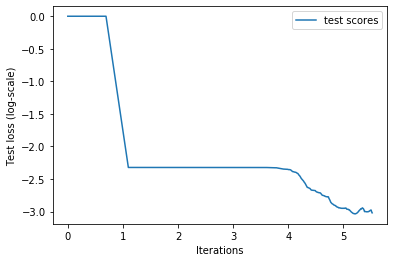

In [25]:
x0 = np.zeros(d) 
niter = 250
delta, k = np.sqrt(1/niter), 3
lamb = (1/3)
z=0.75
test_scores = OSPF(X_train, y_train, x0, niter, hinge_reg_sgd, grad_reg_sgd, proj_l2, X_test, y_test, z, k, delta, lamb)

# Convergence on test set
plt.plot(np.log(range(1, niter+1)), np.log(1-test_scores), label = "test scores")
print("max test scores : {}".format(np.amax(test_scores)))
print("last test scores : {}".format(test_scores[-1]))
plt.xlabel("Iterations")
plt.ylabel("Test loss (log-scale)")
plt.legend()
plt.show()

#### Hyperparameters tuning

In [ ]:
def opt_ospf(xtrain, ytrain, xtest, ytest, cv = 3):
    best_score = -np.inf
    best_z = 0
    
    niter = 500 
    de = np.sqrt(1/niter)
    list_z = [0.5,0.75,1,2]

    for z in list_z:
            
        cv_score = 0
        for _ in range(cv):
            x0 = np.zeros(d) 
            test_scores = OSPF(xtrain, ytrain, x0, niter, hinge_reg_sgd, grad_reg_sgd, proj_l2, xtest, ytest, z, k=5, delta=de)
            cv_score += test_scores[-1]
        cv_score /= cv

        print("z = {}, Cross-val score = {}".format(z, cv_score), "\t")
        if (cv_score >= best_score):
            best_score = cv_score
            best_z = z
                
            
    return best_z

In [ ]:
best_z = opt_ospf(X_train, y_train, X_test, y_test)